## Import libraries

We imported all necessary libraries for:
- Data handling: pandas, numpy
- Visualization: matplotlib, seaborn
- Model training and evaluation: scikit-learn
- Fetching dataset: ucimlrepo
- Visualizing decision trees: graphviz

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import graphviz

## 1. Load and preprocess the dataset

We fetched the Heart Disease dataset from the UCI Machine Learning Repository using the 'ucimlrepo' library.
The dataset was seperated into features ('X') and labels ('y').

Since the original dataset had multiple classes for the target attribute 'num'
We converted it into a binary classification problem:
- '0' represents no heart disease
- '1' represents the presence of heart disease

We then checked the size of the feature matrix and the distribution of the target classes.


In [130]:
# Lấy dữ liệu Heart Disease từ UCI Machine Learning Repository
heart_disease = fetch_ucirepo(id=45)  # 45 là ID của Heart Disease dataset

# Đọc features và labels
X = heart_disease.data.features
y = heart_disease.data.targets['num']  # thường nhãn là cột "num" (0: không bệnh, >0: có bệnh)

# Nếu muốn phân lớp nhị phân: 0 (không bệnh) và 1 (có bệnh)
y = y.apply(lambda x: 1 if x > 0 else 0)

# Kiểm tra
print(X.shape)
print(y.value_counts())

(303, 13)
num
0    164
1    139
Name: count, dtype: int64


## Splitting the Dataset

We split the dataset into training and test sets with the following proportions:
- 40/60
- 60/40
- 80/20
- 90/10

For each split:
- We shuffled the data to avoid any ordering bias
- We used stratified sampling to maintain the original class distribution in both training and test sets
- The random_state parameter was set to 42 to ensure reproducibility
- Each split was stored for further training and evaluation steps

In [131]:
ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
split_datasets = []

for train_ratio, test_ratio in ratios:
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y,
        test_size=test_ratio,
        stratify=y,
        random_state=42,
        shuffle=True
    )
    split_datasets.append((train_ratio, feature_train, feature_test, label_train, label_test))


## Visualizing class distributions and Training the Decision Tree

For each training/test split:

- We plotted the class distribution in the training and test sets to verify that stratified sampling preserved the original class proportions
- We trained a Decision Tree classifier using the "entropy" criterion
- We evaluated the model performance on the test set using:
    - Accuracy
    - Classification report (Precision, Recall, F1-Score)
    - Confusion Matrix

The confusion matrices were visualized to show the prediction results for each split

                                               40/60 split                                               


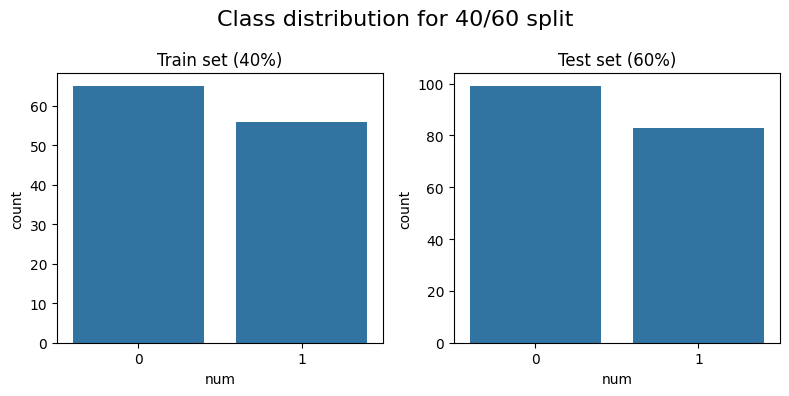

                                               60/40 split                                               


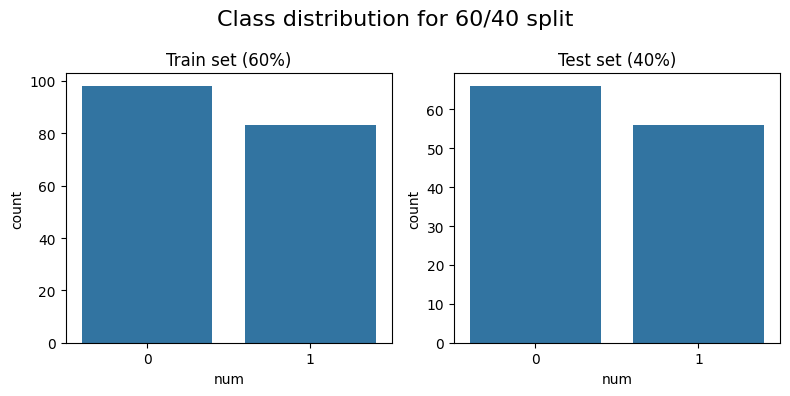

                                               80/20 split                                               


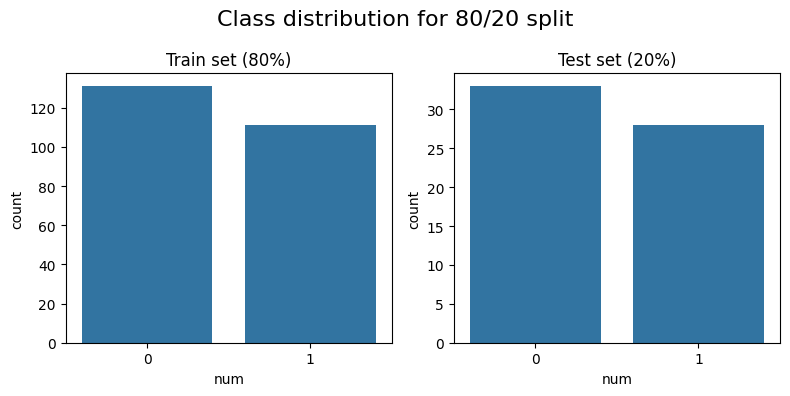

                                               90/10 split                                               


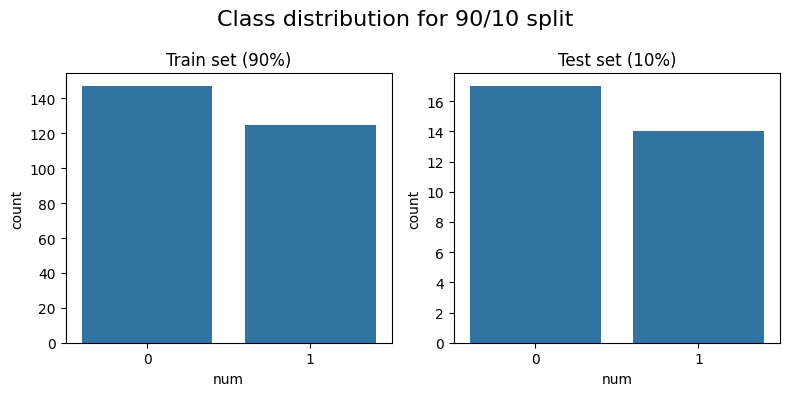

In [132]:
for i, (ratio, feature_train, feature_test, label_train, label_test) in enumerate(split_datasets):
    # vẽ phân bố class
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    sns.countplot(x=label_train, ax=axes[0])
    axes[0].set_title(f"Train set ({round(ratio*100)}%)")
    sns.countplot(x=label_test, ax=axes[1])
    axes[1].set_title(f"Test set ({round((1-ratio)*100)}%)")
    
    print("=======================================================================================================")
    print(f"{round(ratio*100)}/{round((1-ratio)*100)} split".center(105))
    print("=======================================================================================================")
    
    plt.suptitle(f"Class distribution for {round(ratio*100)}/{round((1-ratio)*100)} split", fontsize=16)
    plt.tight_layout()
    plt.show()

## Building the Decision Tree Classifiers

We conducted experiments on different train/test splits by training a Decision classifier for each split

- We used 'DecisionTreeClassifier' with the 'entropy' criterion to maximize information gain during node splits
- For each training set:
    - We fitted the Decision Tree model on the corresponding training data
    - We visualized the resulting Decision Tree using Graphviz by exporting the structure into PNG images
- The visualization of the Decision Trees allows us to observe the splitting conditions, entropy at each node, number of samples, and the predicted class
- After training, we evaluated each model on the test set by computing:
    - Accuracy score
    - Detailed classification reports (precision, recall and F1-score for both classes)
    - Confusion matrices to visualize prediction correctness

Each Decision Tree structure gives insight into how the model classifies patients as having heart disease or not based on the input features

Decision Tree for split 40/60:


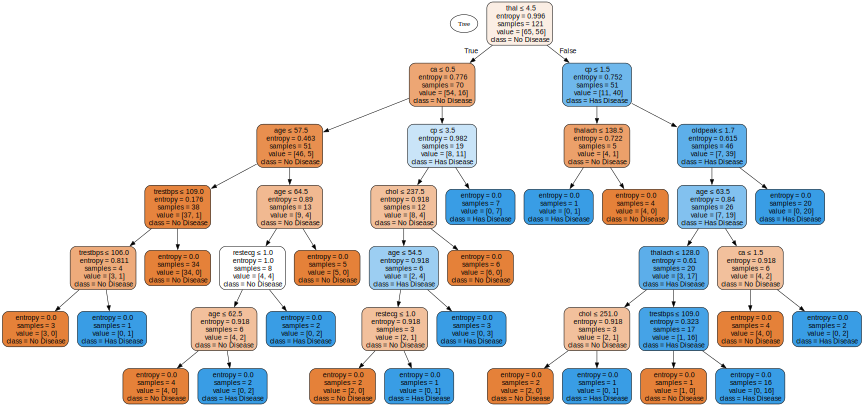

==================== Split 40/60 ====================
Accuracy: 0.7307692307692307
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        99
           1       0.67      0.80      0.73        83

    accuracy                           0.73       182
   macro avg       0.74      0.74      0.73       182
weighted avg       0.74      0.73      0.73       182

Confusion Matrix:
[[67 32]
 [17 66]]
Decision Tree for split 60/40:


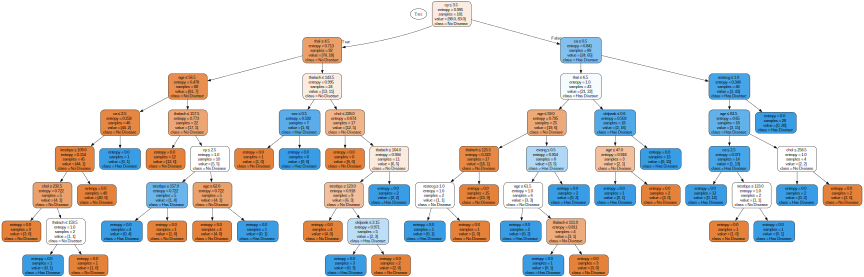

==================== Split 60/40 ====================
Accuracy: 0.7540983606557377
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        66
           1       0.72      0.77      0.74        56

    accuracy                           0.75       122
   macro avg       0.75      0.76      0.75       122
weighted avg       0.76      0.75      0.75       122

Confusion Matrix:
[[49 17]
 [13 43]]
Decision Tree for split 80/20:


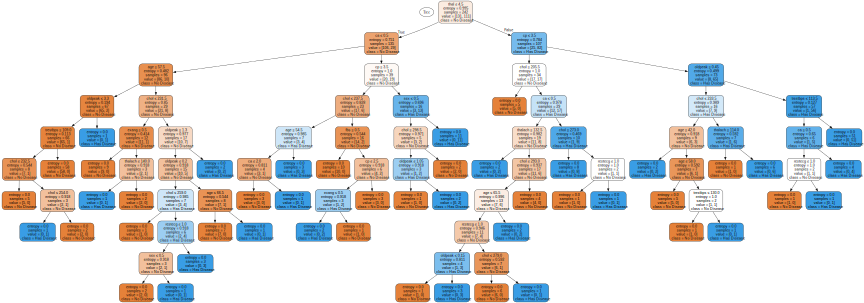

==================== Split 80/20 ====================
Accuracy: 0.7704918032786885
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        33
           1       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61

Confusion Matrix:
[[22 11]
 [ 3 25]]
Decision Tree for split 90/10:


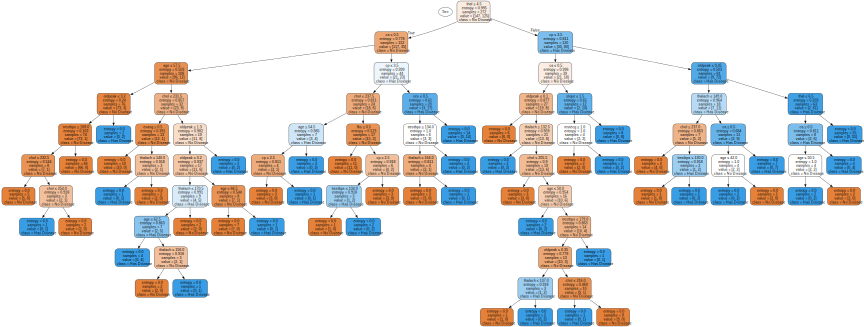

==================== Split 90/10 ====================
Accuracy: 0.7419354838709677
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.65      0.93      0.76        14

    accuracy                           0.74        31
   macro avg       0.78      0.76      0.74        31
weighted avg       0.79      0.74      0.74        31

Confusion Matrix:
[[10  7]
 [ 1 13]]


In [133]:
def draw_decision_tree(clf, feature_names):
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=["No Disease", "Has Disease"],
        filled=True,
        rounded=True,
        special_characters=True
    )
    dot_data = f'digraph G {{size="12,10"; {dot_data[8:]}}}'
    graph = graphviz.Source(dot_data)
    # graph.render(filename, format='png', cleanup=True)
    return graph

# Huấn luyện và vẽ cây cho mỗi tỉ lệ
for ratio, feature_train, feature_test, label_train, label_test in split_datasets:
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(feature_train, label_train)

    # Vẽ cây
    # filename = f"tree_{round(ratio*100)}_{round((1-ratio)*100)}"
    # draw_decision_tree(clf, X.columns, filename)
    print(f"Decision Tree for split {round(ratio*100)}/{round((1-ratio)*100)}:")
    tree_graph = draw_decision_tree(clf, X.columns)
    display(tree_graph)

    # Đánh giá
    y_pred = clf.predict(feature_test)
    print(f"==================== Split {round(ratio*100)}/{round((1-ratio)*100)} ====================")
    print("Accuracy:", accuracy_score(label_test, y_pred))
    print("Classification Report:")
    print(classification_report(label_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(label_test, y_pred))
    print(f"=====================================================")


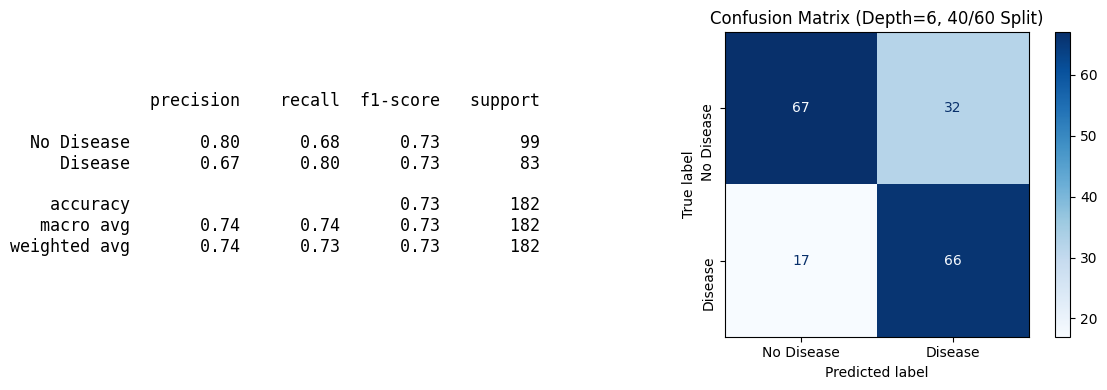

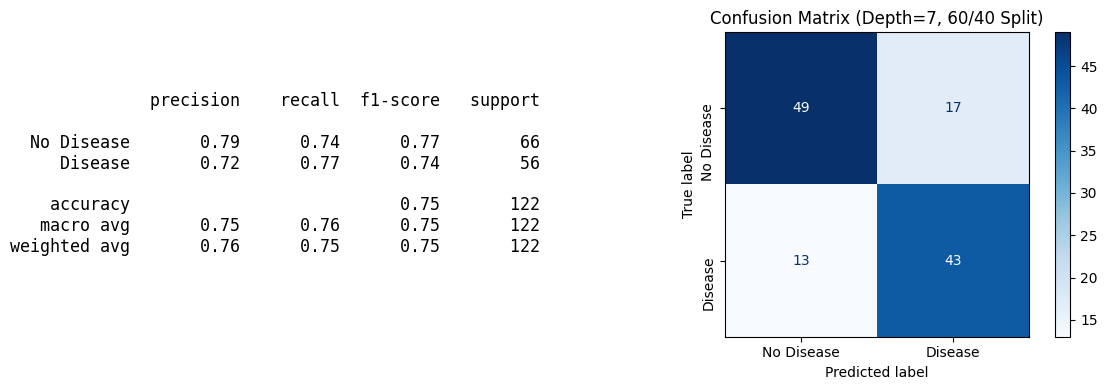

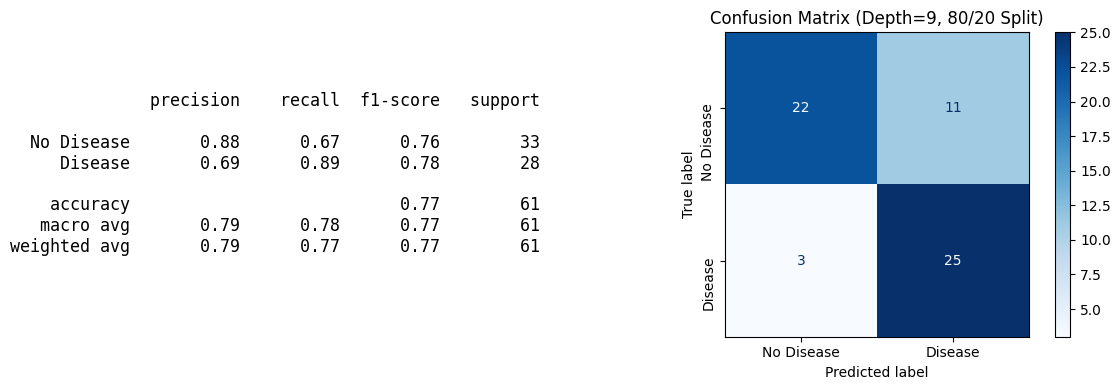

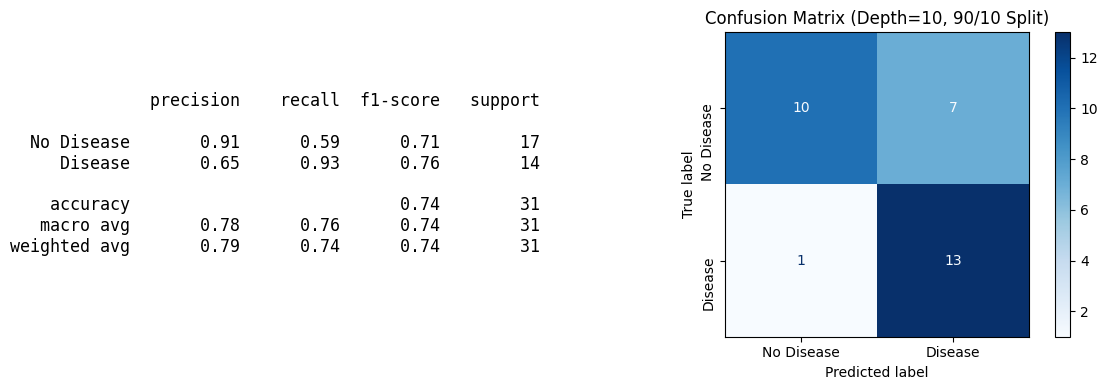

In [134]:
for i, (ratio, feature_train, feature_test, label_train, label_test) in enumerate(split_datasets):
    # đánh giá mô hình và vẽ confusion matrix
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(feature_train, label_train)
    y_pred = clf.predict(feature_test)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    report = classification_report(label_test, y_pred, target_names=['No Disease', 'Disease'])
    axes[0].axis('off')
    axes[0].text(0.5, 0.5, report, fontsize=12, fontfamily='monospace', ha='center', va='center')
    
    cm = confusion_matrix(label_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
    disp.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=True)
    for patch in disp.ax_.patches:
        patch.set_edgecolor('None')
        
    axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=90)
    axes[1].set_title(f'Confusion Matrix (Depth={clf.get_depth()}, {round(ratio*100)}/{round((1 - ratio)*100)} Split)')
    
    plt.tight_layout()
    plt.show()

Decision Tree for max_depth=None:


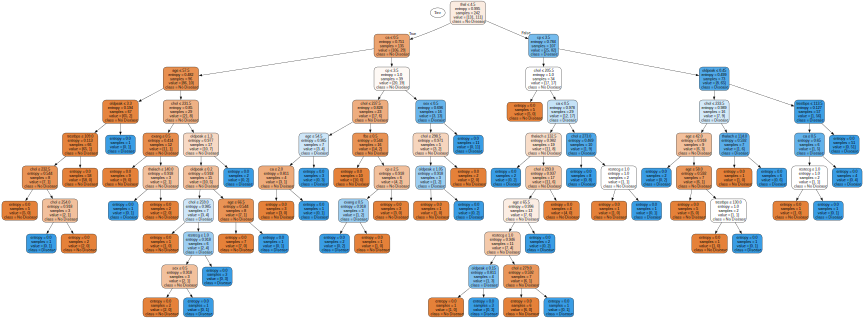

Decision Tree for max_depth=2:


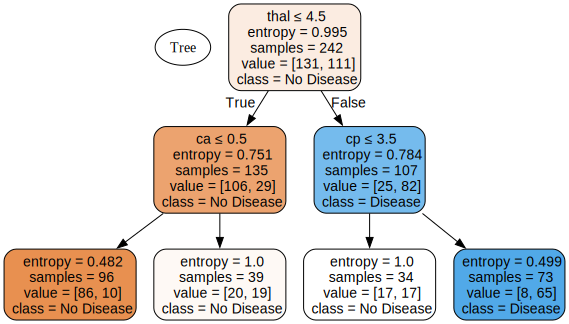

Decision Tree for max_depth=3:


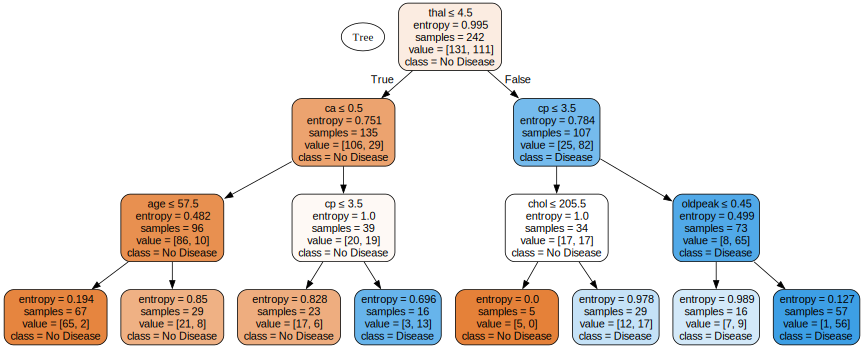

Decision Tree for max_depth=4:


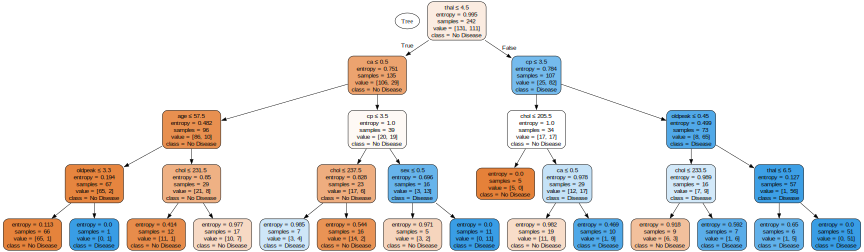

Decision Tree for max_depth=5:


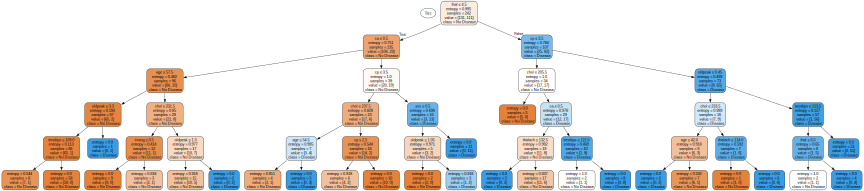

Decision Tree for max_depth=6:


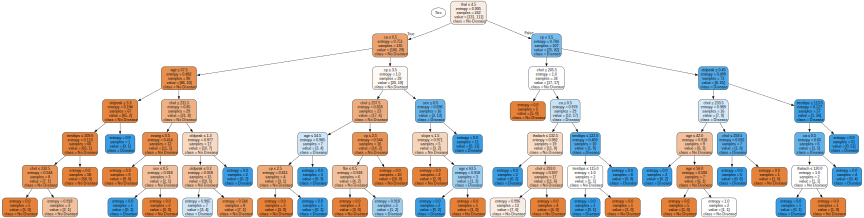

Decision Tree for max_depth=7:


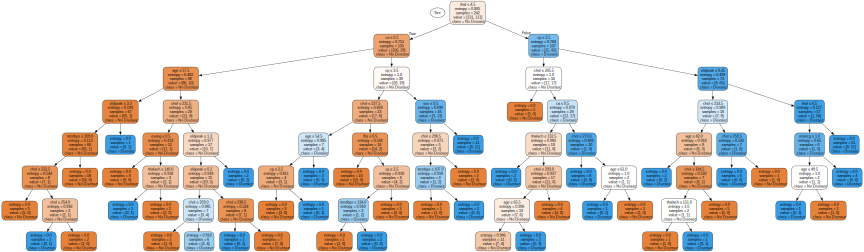

Accuracy Table
------------------------------------------------------------------------
max_depth    None     2        3        4        5        6        7       
Accuracy     0.770    0.770    0.787    0.787    0.803    0.705    0.689   
------------------------------------------------------------------------



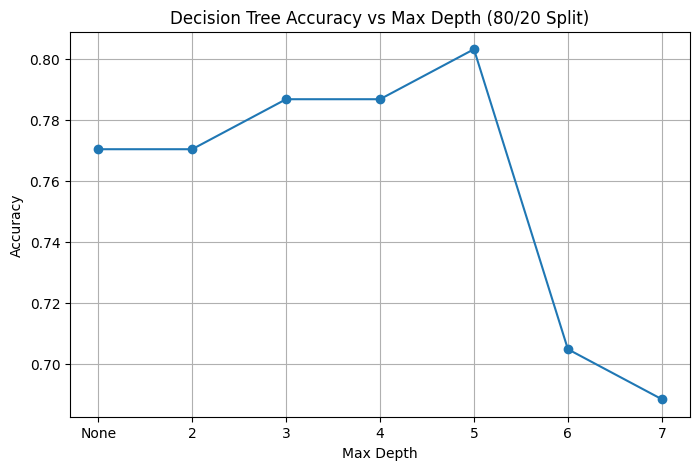

In [135]:
max_depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

# chọn bộ 80/20 trong split_datasets
for ratio, feature_train, feature_test, label_train, label_test in split_datasets:
    if round(ratio, 1) == 0.8:
        break
    
trees = []
    
for depth in max_depths:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=42)
    clf.fit(feature_train, label_train)
    y_pred = clf.predict(feature_test)
    acc = accuracy_score(label_test, y_pred)
    accuracies.append(acc)
    
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=['No Disease', 'Disease'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    dot_data = f'digraph G {{size="12,10"; {dot_data[8:]}}}'
    graph = graphviz.Source(dot_data)
    # graph.render(f"decision_tree_depth_{depth if depth is not None else 'None'}", format='png', cleanup=True)
    trees.append(graph)
    
for i, (depth, tree) in enumerate(zip(max_depths, trees)):
    print(f"Decision Tree for max_depth={depth if depth is not None else 'None'}:")
    display(tree)
    
    
depth_labels = ['None' if d is None else str(d) for d in max_depths]
accuracy_values = [f"{acc:.3f}" for acc in accuracies]

table_str = "Accuracy Table\n"
table_str += "------------------------------------------------------------------------\n"
table_str += f"{'max_depth':<12} {' '.join([f'{label:<8}' for label in depth_labels])}\n"
table_str += f"{'Accuracy':<12} {' '.join([f'{acc:<8}' for acc in accuracy_values])}\n"
table_str += "------------------------------------------------------------------------\n"

print(table_str)
    
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
depth_labels = ['None' if d is None else str(d) for d in max_depths]
plt.plot(depth_labels, accuracies, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs Max Depth (80/20 Split)")
plt.grid(True)
plt.show()